In [1]:
import pandas as pd
from ast import literal_eval
from itertools import product
from itertools import permutations
import networkx as nx
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import community as community_louvain

In [2]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv"
paf=pd.read_csv(pubs_path)
paf['author_country'] = paf['author_country'].apply(literal_eval)
paf['funder_country'] = paf['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
paf['authorlist']=paf['author_country'].apply(lambda x:list(set(x)))

In [4]:
paf['funderlist']=paf['funder_country'].apply(lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')

In [5]:
def build_network(data, col):
    network=[]
    colvalue=data[col].to_numpy()
    for cntrys in colvalue:
        for c1,c2 in combinations(cntrys,2):
            network.append([c1,c2])
            network.append([c2,c1])
    return network

In [31]:
fundnet=build_network(paf[paf.funder_country!='Not-Funded'],'funderlist')
fundnet = pd.DataFrame(fundnet, columns=['cntry1','cntry2'])
fundnet = fundnet.groupby(['cntry1','cntry2']).size().reset_index(name='weight')
fundnet['weight']=np.log(fundnet['weight'])
netfund=nx.from_pandas_edgelist(fundnet, source='cntry1', target='cntry2', edge_attr='weight')

In [32]:
colnet=build_network(paf,'authorlist')
colnet=pd.DataFrame(colnet, columns=['cntry1','cntry2'])
colnet=colnet.groupby(['cntry1','cntry2']).size().reset_index(name='weight')
colnet['weight']=np.log(colnet['weight'])
netcol=nx.from_pandas_edgelist(colnet, source='cntry1', target='cntry2', edge_attr='weight')

investigate the pcc of edge weights

In [8]:
weightmeta = colnet.merge(fundnet, on=['cntry1','cntry2'])

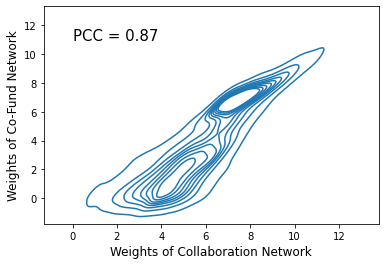

In [67]:
fig, ax=plt.subplots()
sns.kdeplot(x='weight_col',y='weight_fund',data=weightmeta,ax=ax)
pcc = np.corrcoef(weightmeta.weight_col.values, weightmeta.weight_fund.values)[0][1]
pcc=np.round(pcc,2)
s=f"PCC = {pcc}"
plt.text(0,11,s,fontsize=15)
plt.xlabel("Weights of Collaboration Network",fontsize=12)
plt.ylabel("Weights of Co-Fund Network",fontsize=12)
plt.savefig("edges_weights.pdf")

detect the community structure of the networks

In [13]:
comfund_dict=community_louvain.best_partition(netfund, weight='weight')
comfund = pd.DataFrame.from_dict(comfund_dict,orient='index').reset_index()
comfund.columns=['cntry','fund_com']

In [15]:
comcol_dict=community_louvain.best_partition(netcol, weight='weight')
comcol = pd.DataFrame.from_dict(comcol_dict,orient='index').reset_index()
comcol.columns=['cntry','col_com']

In [30]:
commeta=comfund.merge(comcol, on='cntry')

In [13]:
ccfund = nx.betweenness_centrality(netfund)
ccfund=pd.DataFrame.from_dict(ccfund, orient='index').reset_index()
ccfund.columns=['cntry','fund_cc']

In [14]:
cccol = nx.betweenness_centrality(netcol)
cccol=pd.DataFrame.from_dict(cccol, orient='index').reset_index()
cccol.columns=['cntry','col_cc']

In [41]:
ccmeta=cccol.merge(ccfund, on='cntry',how='left')

<AxesSubplot:xlabel='col_cc', ylabel='fund_cc'>

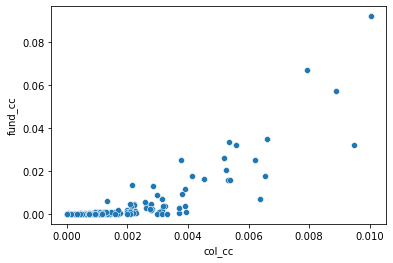

In [43]:
sns.scatterplot(x='col_cc',y='fund_cc',data=ccmeta)

In [68]:
def extract_backbone(G, alpha):
    """ network backbone extraction using the multi-scale backbone algorithm
    by Serrano et al., PNAS.

    source:
    https://gist.github.com/bagrow/11181518#file-extract_backbone-py

    """
    keep_graph = nx.Graph()
    for n in G:
        k_n = len(G[n])
        if k_n > 1:
            sum_w = G.degree(n, weight="weight")
            for nj in G[n]:
                pij = 1.0 * G[n][nj]["weight"] / sum_w
                if (1 - pij) ** (k_n - 1) < alpha:  # edge is significant
                    keep_graph.add_edge(n, nj, weight=G[n][nj]["weight"])
    return keep_graph

In [73]:
colfilter=extract_backbone(netcol,0.1)

In [75]:
colfilter.number_of_edges()

2904

In [88]:
fundfilter=extract_backbone(netfund,0.4)

In [89]:
fundfilter.number_of_edges()

2396

In [91]:
nx.write_gexf(fundfilter, "fund_backbone04.gexf")

In [92]:
nx.write_gexf(colfilter,'col_backbone01.gexf')